In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 使用预训练的卷积神经网络
-----
-----

* 要想将深度学习应用于小数据集，一个常用且高效的方法是使用预训练网络。预训练网络是一个保存好的网络，之前已经在大型数据集（通常是大规模图像分类任务）上训练好。
* 如果原始的大型数据集足够大且足够通用，因此这些特征可用于不同的计算机视觉问题，即使新问题涉及的类别和原始类别完全不同。
* 这种学到的特征在不同问题之间的可移植性，是深度学习与许多早期浅层学习方法相比所具有的重要优势，这使得深度学习对小数据特别有效。
* 本例中，假设有一个在ImageNet数据集（140万标记图片，1000个不同种类）上训练好的大型神经网络。ImageNet中包含许多动物类别，其中包括不同种类的猫狗，因此认为它在猫狗分类问题中也有良好表现。
* 我们使用VGG16架构，虽然它比较陈旧，性能也比不上当前的先进模型，而且它还比许多新模型更为复杂。这里选择使用它，仅仅是因为它的架构与之前介绍的架构很相似，这样无需引入新概念便可理解。
* 使用预训练有两种方法：特征提取，模型微调。先来看特征提取：

## 特征提取
-----
* 特征提取是使用从之前网络学到的表示来从新样本中提取有趣的特征，然后将这些特征输入到一个新的分类器，从头开始训练。
* 用于图像分类的卷积神经网络包括两部分：先是多个卷积层和池化层，然后是一个全连接层。第一部分叫卷积基。
* 对于神经网络而言，特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上面训练一个新的分类器。

<img src="https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png" width = 40% height = 50% />    


* 为什么仅仅使用卷积基？密集连接分类器是否也可以重用？一般来说应避免这么做。原因是卷积基学到的表示可能更加通用，因此可以重复使用。
* 卷积神经网络的特征图表示了通用概念在图像中是否存在，无论面对什么视觉问题，这种特征图都可能有用。
* 但是，分类器学到的表示必然是针对模型训练的类别，其中仅包含某个类别出现在整张图中的概率。而且，密集连接层舍弃了空间信息，而位置信息仍然由卷积特征图表示。如果物体位置对于问题很重要，那么密集连接层的特征在很大程度上是无用的。
* 某个卷积层提取的表示的通用性（或可复用性）取决于该层在模型中的深度。模型中靠近底层的提取的是局部的、高度通用的特征图（比如视觉边缘、颜色、纹理），而更靠近顶层的则是更加抽象的概念（如猫耳朵，狗眼睛）。
* 因此，<font color='red'>如果新数据集与原始模型训练的数据集有很大差异，最好只使用模型的前几层来做特征提取，而不是使用整个卷积基</font>。
* 本例中，由于ImageNet中包含猫狗的类别，所以重复使用密集连接层包含的信息可能很有用。但我们不这么做，以便涵盖原始数据集与新问题不同的情况。
* 我们实践一下，使用在ImageNet上训练的VGG17网络的卷积基从猫狗图像中提取有趣的特征，然后在这些特征上训练一个猫狗分类器。

VGG模型和其它的模型已经预先打包在keras里，可以从`keras.applications`模块中导入。下面是一些预先打包好的模型（都是基于ImageNet训练得到的）：

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

我们实例化一下VGG16模型:

In [2]:
# 将 VGG16 卷积基实例化
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

向构造函数中传入了三个参数。
* weights 指定模型初始化的权重检查点。
* include_top 指定模型最后是否包含密集连接分类器。默认情况下，这个密集连接分类器对应于 ImageNet 的 1000 个类别。因为我们打算使用自己的密集连接分类器（只有
两个类别：cat 和 dog），所以不需要包含它。
* input_shape 是输入到网络中的图像张量的形状。这个参数完全是可选的，如果不传入这个参数，那么网络能够处理任意形状的输入。 

VGG16 卷积基的详细架构如下所示。

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

最后一层输出的特征图形状为 (4, 4, 512)。我们将在这个特征上添加一个密集连接分类器。

接下来，下一步有2种选择可供选择：
* 在新的数据集上运行卷积基，将输出保存成硬盘上的numpy数组，然后用这个数据作为输入，输入到独立的密集连接分类器中。  
  这种方法优点是`速度快，计算代价低`；相反的缺点就是这种方法`不允许使用数据增强`。
* 在顶层添加Dense层来扩展已有模型，并在输入数据上端到端地运行整个模型。这样便可以使用数据增强，因为每个图形都会经过卷积基。
    但出于同样的原因，这种方法的计算代价要比第一种高出很多。
    
首先看第一种方法：在卷积基上运行数据，并保存输出，然后将这些输出作为输入用于新模型。

### 1. 不使用数据增强的快速特征提取  
----
首先，运行 ImageDataGenerator 实例，将图像及其标签提取为 Numpy 数组。我们需要调用 conv_base 模型的 predict 方法来从这些图像中提取特征。  
不使用数据增强的快速特征提取，这种方法就是，利用模型的卷积基对数据进行运算，输出结果保存为Numpy数组，后续使用此数据继续在全连接层上继续计算。  
<font color='red'>反思： 所谓predict方法，现在理解就是，针对模型输入数据，根据模型中的各种算法（各种激活函数）对输入数据一层一层的计算下来。计算的结果，依赖于最后一个激活函数的输出。</font>

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
# 存放训练集，验证集、测试集的根目录
#base_dir = '/home/lys/aidata/catdogs/newdir'  # for linux
base_dir = 'D:\\mldata\\catdogs\\newdir' 

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 注意，这些生成器在循环中不断生成数据，所以你必须在读取完所有图像后终止循环
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# extract_features方法原理探究,无需执行
def extract_features1(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        print('inputs_batch.shape:',inputs_batch.shape)
        #print('inputs_batch[0] : ',inputs_batch[0])
        print('labels_batch.shape:',labels_batch.shape)
        print('labels_batch[0] : ',labels_batch[0])
        features_batch = conv_base.predict(inputs_batch)
        print('features_batch.shape:',features_batch.shape) # 可以预见，与模型的最后输出的shape相同
        # 把生成好的特征塞入features中，注意第一维度按批次存放
        # 因为生成器的批次设置为20，因此第一次循环是0~20，第二次是20~40如此循环，直至最后的1980~2000结束
        features[i * batch_size: (i + 1) * batch_size] = features_batch 
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= 20:  # 为探究方便，改成处理20个图像就退出
            # 注意，这些生成器在循环中不断生成数据，所以必须在读取完所有图像后终止循环
            break
    return features, labels
train_features1, train_labels1 = extract_features1(train_dir, 2000)

目前，提取的特征形状为 (samples, 4, 4, 512)。我们要将其输入到密集连接分类器中，所以首先必须将其形状展平为 (samples, 8192)

In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

现在可以定义全连接分类器（注意要使用 dropout 正则化），并在刚刚保存的数据和标签上训练这个分类器:

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6199 - acc: 0.6540 - val_loss: 0.4291 - val_acc: 0.8360
Epoch 2/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4234 - acc: 0.8135 - val_loss: 0.3549 - val_acc: 0.8720
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3433 - acc: 0.8565 - val_loss: 0.3281 - val_acc: 0.8570
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3078 - acc: 0.8720 - val_loss: 0.2957 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2839 - acc: 0.8875 - val_loss: 0.2771 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2581 - acc: 0.9005 - val_loss: 0.2733 - val_acc: 0.8960
Epoch 7/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2473 - acc: 0.9000 - val_loss: 0.2610 - val_acc: 0.8980
Epoch 8/30
200

训练速度非常快，因为只需处理两个 Dense 层。

我们来看一下训练期间的损失曲线和精度曲线

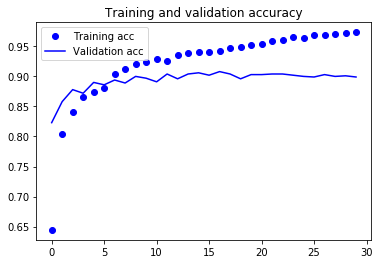

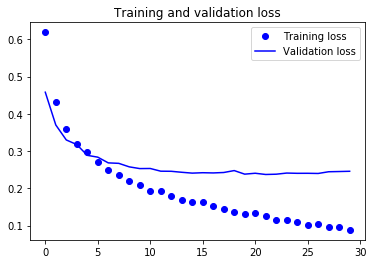

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


我们的验证精度达到了约 90%，比上一节从头开始训练的小型模型效果要好得多。但从图中也可以看出，虽然 dropout 比率相当大，
但模型几乎从一开始就过拟合。这是因为本方法没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。


### 2. 使用数据增强的特征提取
----

特征提取的第二种方法，它的速度更慢，计算代价更高，但在训练期间可以使用数据增强。这种方法就是：扩展 conv_base模型，然后在输入数据上端到端地运行模型。  
模型的行为和层类似，所以你可以向 Sequential模型中添加一个模型（比如 conv_base），就像添加一个层一样。

In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
# 现在模型的架构如下所示:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


如上所示，VGG16 的卷积基有 14 714 688 个参数，非常多。在其上添加的分类器有 200 万个参数。  
在编译和训练模型之前，一定要<font color='red'>“冻结”卷积基</font>。冻结（freeze）一个或多个层是指在训练过程中保持其权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。  
因为其上添加的 Dense 层是随机初始化的，所以非常大的权重更新将会在网络中传播，对之前学到的表示造成很大破坏。  
在 Keras 中，冻结网络的方法是将其 trainable 属性设为 False。  

In [9]:
# 冻结卷积基之前可训练的权重张量的数量：
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


如此设置之后，只有添加的两个 Dense 层的权重才会被训练。总共有 4 个权重张量，每层2 个（主权重矩阵和偏置向量）。  
注意，为了让这些修改生效，你必须先编译模型。如果在编译之后修改了权重的 trainable 属性，那么应该重新编译模型，否则这些修改将被忽略。

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 注意，验证集不能被加强
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [15]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

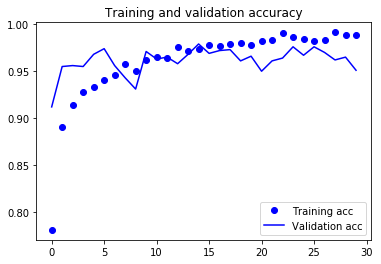

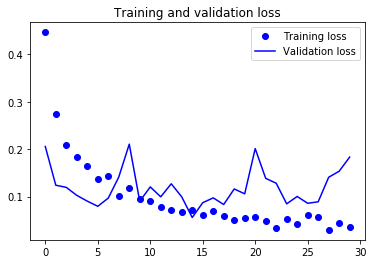

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

如图所示，我们得到大概96%的验证精度，这比之前从零起步的小卷积网络好很多。

## 模型微调
----
另一种广泛使用的模型复用方法是模型微调（fine-tuning），与特征提取互为补充。  
对于用于特征提取的冻结的模型基，微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分（本例中是全连接分类器）联合训练。  
之所以叫作微调，是因为它只是略微调整了所复用模型中更加抽象的表示，以便让这些表示与手头的问题更加相关。  
在下图中，我们“解冻”第五层并微调：

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

前面说过，冻结 VGG16 的卷积基是为了能够在上面训练一个随机初始化的分类器。    
同理，只有上面的分类器已经训练好了，才能微调卷积基的顶部几层。如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大，微调的几层之前学到的表示都会被破坏。  
微调网络的步骤如下：  
(1) 在已经训练好的基网络（base network）上添加自定义网络。  
(2) 冻结基网络。  
(3) 训练所添加的部分。  
(4) 解冻基网络的一些层。  
(5) 联合训练解冻的这些层和添加的部分。  


在做特征提取时已经完成了前三个步骤。我们继续进行第四步：先解冻 conv_base，然后冻结其中的部分层。先看看网络架构：

In [13]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

我们将微调最后三个卷积层，也就是说，直到 block4_pool 的所有层都应该被冻结，而block5_conv1、block5_conv2 和 block5_conv3 三层应该是可训练的。
为什么不微调更多层？为什么不微调整个卷积基？你当然可以这么做，但需要考虑以下几点：
* 卷积基中更靠底部的层编码的是更加通用的可复用特征，而更靠顶部的层编码的是更专业化的特征。微调这些更专业化的特征更加有用，因为它们需要在新问题上改变用途。微调更靠底部的层，得到的回报会更少。

* 训练的参数越多，过拟合的风险越大。卷积基有 1500 万个参数，所以在小型数据集上训练这么多参数是有风险的。


因此，在这种情况下，一个好策略是仅微调卷积基最后的两三层。现在从上一个例子结束的地方开始，继续实现此方法。

In [14]:
# 解冻整个网络
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

现在可以开始微调网络。我们将使用学习率非常小的 RMSProp 优化器来实现。之所以让学习率很小，是因为对于微调的三层表示，我们希望其变化范围不要太大。太大的权重更新可
能会破坏这些表示。

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 452s 5s/step - loss: 0.5681 - acc: 0.7000 - val_loss: 0.3668 - val_acc: 0.8510
Epoch 2/100
100/100 [==============================] - 525s 5s/step - loss: 0.3964 - acc: 0.8195 - val_loss: 0.2623 - val_acc: 0.8930
Epoch 3/100
100/100 [==============================] - 477s 5s/step - loss: 0.3180 - acc: 0.8680 - val_loss: 0.2266 - val_acc: 0.9070
Epoch 4/100
100/100 [==============================] - 507s 5s/step - loss: 0.3011 - acc: 0.8730 - val_loss: 0.2326 - val_acc: 0.8980
Epoch 5/100
100/100 [==============================] - 509s 5s/step - loss: 0.2736 - acc: 0.8785 - val_loss: 0.2435 - val_acc: 0.9000
Epoch 6/100
100/100 [==============================] - 517s 5s/step - loss: 0.2630 - acc: 0.8855 - val_loss: 0.1954 - val_acc: 0.9210
Epoch 7/100
100/100 [==============================] - 527s 5s/step - loss: 0.2467 - acc: 0.9035 - val_loss: 0.1919 - val_acc: 0.9230
Epoch 8/100
100/100 [==============================] - 516s 5s

Epoch 62/100
100/100 [==============================] - 546s 5s/step - loss: 0.0436 - acc: 0.9815 - val_loss: 0.2557 - val_acc: 0.9260
Epoch 63/100
100/100 [==============================] - 608s 6s/step - loss: 0.0448 - acc: 0.9845 - val_loss: 0.2890 - val_acc: 0.9290
Epoch 64/100
100/100 [==============================] - 688s 7s/step - loss: 0.0435 - acc: 0.9855 - val_loss: 0.3280 - val_acc: 0.9200
Epoch 65/100
100/100 [==============================] - 677s 7s/step - loss: 0.0438 - acc: 0.9880 - val_loss: 0.2198 - val_acc: 0.9400
Epoch 66/100
100/100 [==============================] - 682s 7s/step - loss: 0.0473 - acc: 0.9870 - val_loss: 0.2151 - val_acc: 0.9380
Epoch 67/100
100/100 [==============================] - 701s 7s/step - loss: 0.0462 - acc: 0.9790 - val_loss: 0.2114 - val_acc: 0.9420
Epoch 68/100
100/100 [==============================] - 7913s 79s/step - loss: 0.0413 - acc: 0.9855 - val_loss: 0.2165 - val_acc: 0.9380
Epoch 69/100
100/100 [==============================]

In [16]:
model.save('cats_and_dogs_small_4.h5')

画一下精确度和损失值的对比图:

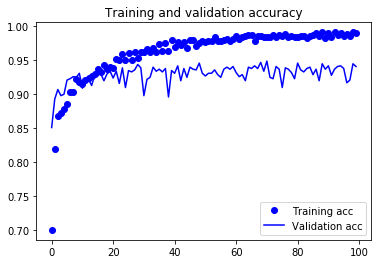

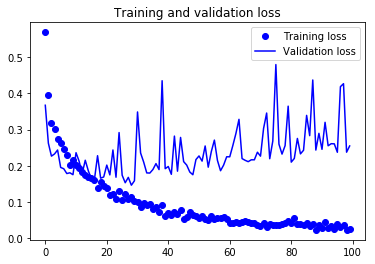

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


这些曲线看起来包含噪声。为了让图像更具可读性，可以将每个损失和精度都替换为指数移动平均值，从而<font size='3' color='green'>让曲线变得平滑</font>。  
下面用一个简单的实用函数来实现:

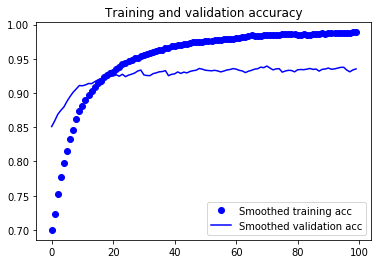

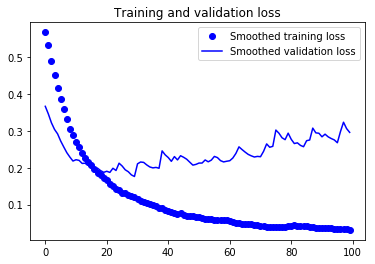

In [20]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


曲线看起来清晰稳定，可以看到精度大约提高了1%。

现在，可以在测试数据上最终评估这个模型：

In [27]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.967999992371


## 小结: 在小数据集上使用卷积

下面是从以上两节的练习中学到的要点：
* 卷积神经网络是用于计算机视觉任务的最佳机器学习模型。即使在非常小的数据集上也可以从头开始训练一个卷积神经网络，而且得到的结果还不错。
* 在小型数据集上的主要问题是过拟合。在处理图像数据时，数据增强是一种降低过拟合的强大方法。
* 利用特征提取，可以很容易将现有的卷积神经网络复用于新的数据集。对于小型图像数据集，这是一种很有价值的方法。
* 作为特征提取的补充，你还可以使用微调，将现有模型之前学到的一些数据表示应用于新问题。这种方法可以进一步提高模型性能。
现在已经拥有一套可靠的工具来处理图像分类问题，特别是对于小型数据集。